<a href="https://colab.research.google.com/github/adenikeadewumi/Emotion-Recognition-Model/blob/main/Emotion_Recognition_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Processing

In [ ]:
# Basic python libraries.
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get rid of warnings!
import warnings
warnings.filterwarnings('ignore')

#Deep learning libraries
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
#import copy
import cv2
from typing import Tuple, Callable, Union, Any
print("Importation done")

Importation done


Import the data


In [ ]:
path= "/content/archive (14).zip"

In [ ]:
from zipfile import ZipFile
with ZipFile(path , 'r') as ZipFile:
  ZipFile.extractall()
  print('Zip file extracted successfully')

Zip file extracted successfully


In [ ]:
train_dir= "/content/train"
test_dir= "/content/test"


In [ ]:
emotions_categories= os.listdir(train_dir)
print(emotions_categories)
emotion_dict= {i: emotions_categories[i] for i in range(len(emotions_categories))}
print(emotion_dict)

['disgust', 'fear', 'angry', 'neutral', 'sad', 'happy', 'surprise']
{0: 'disgust', 1: 'fear', 2: 'angry', 3: 'neutral', 4: 'sad', 5: 'happy', 6: 'surprise'}


Data Preprocessing

Visualize some of the data

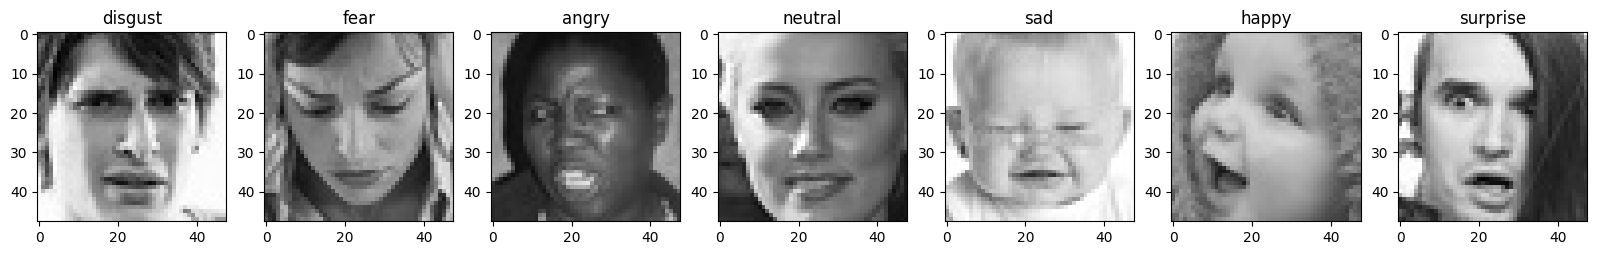

In [ ]:
plt.figure(figsize=(20, 25))
for emotion in emotions_categories:
  img_path= os.path.join(train_dir, emotion)
  img_path= os.path.join(img_path, os.listdir(img_path)[60])
  img= cv2.imread(img_path)
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(1,7, emotions_categories.index(emotion)+1)
  plt.imshow(img)
  plt.title(emotion)

Data Augmentation

In [ ]:
#Create a transform to apply to the test and train data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),         # data augmentation
    transforms.RandomRotation(10),             # data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # normalize to [-1, 1]
])

In [ ]:
#Load the train and test data
train_data= torchvision.datasets.ImageFolder(root= train_dir, transform= transform)
test_data= torchvision.datasets.ImageFolder(root= test_dir, transform= transform)
img, label = train_data[0]  # Get first image and its label
print(img.shape)

torch.Size([3, 48, 48])


WeightRandomSampler

In [ ]:
from torch.utils.data import WeightedRandomSampler
import numpy as np
from collections import Counter

# Get all targets (labels) from train_data
targets = [label for _, label in train_data]

# Count class occurrences
class_counts = Counter(targets)
num_samples = len(targets)

# Compute weights for each class: inversely proportional to frequency
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# Assign a weight to each sample based on its class
sample_weights = [class_weights[label] for label in targets]

# Create the sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


In [ ]:
# Create train and test loader and apply sampler to the train to prevent undersampling of less data classes
train_loader= DataLoader(train_data, batch_size= 32, sampler= sampler)
test_loader= DataLoader(test_data, batch_size= 32, shuffle= False)

In [ ]:
for images, labels in train_loader:
  print(labels)
  break

tensor([1, 3, 2, 0, 6, 6, 0, 3, 0, 1, 0, 1, 5, 4, 0, 2, 4, 1, 6, 2, 1, 3, 3, 2,
        2, 1, 4, 5, 3, 4, 3, 2])


Create the model

In [ ]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # Activation and maxpool layers
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.2)

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Fully Connected Layer
        # After applying 3 convolutional layers and 3 pooling layers on a 48x48 image,
        # The final output shape will be [256, 6, 6].
        self.fc1 = nn.Linear(256 * 6 * 6, 1024)

        # Optional output layer for classification
        self.fc2 = nn.Linear(1024, 7)  # Assuming 7 output classes

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        # Flatten the tensor for fully connected layer
        x = x.view(x.size(0), -1)

        # First fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Optional output layer for classification
        x = self.fc2(x)


        return x

# Example of how you would create and use this model
# Example of how you would create and use this model
simplified_model = Model()
print(simplified_model)

Model(
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=9216, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=7, bias=True)
)


Train Model

In [ ]:
#set training parameters
learning_rate= 1e-4
EPOCHS= 10
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(simplified_model.parameters(), lr= learning_rate)

In [ ]:
for epoch in range(EPOCHS):
  for i, data in enumerate(train_loader):
    # Unpack data to get the inputs for the model and their corresponding labels
    inputs, labels= data
    #Get model's prediction
    outputs= simplified_model(inputs)

    #Compute the loss
    loss= criterion(outputs, labels)

    # Set gradients to xeor
    optimizer.zero_grad()

    # Use loss cost to update the weight parameters
    loss.backward()

    optimizer.step()
    if i % 100 == 99:
      print('Epoch [{}/{}], batch {}, Loss: {:.4f}'.format(epoch+1, EPOCHS, i+1, loss.item()))


Epoch [1/10], batch 100, Loss: 1.9099
Epoch [1/10], batch 200, Loss: 1.7214
Epoch [1/10], batch 300, Loss: 1.7688
Epoch [1/10], batch 400, Loss: 1.9610
Epoch [1/10], batch 500, Loss: 1.9276
Epoch [1/10], batch 600, Loss: 1.7783
Epoch [1/10], batch 700, Loss: 1.7186
Epoch [1/10], batch 800, Loss: 1.9242
Epoch [2/10], batch 100, Loss: 1.8003
Epoch [2/10], batch 200, Loss: 1.4751
Epoch [2/10], batch 300, Loss: 1.5645
Epoch [2/10], batch 400, Loss: 1.6691
Epoch [2/10], batch 500, Loss: 1.7006
Epoch [2/10], batch 600, Loss: 1.7782
Epoch [2/10], batch 700, Loss: 1.6332
Epoch [2/10], batch 800, Loss: 1.1191
Epoch [3/10], batch 100, Loss: 1.7093
Epoch [3/10], batch 200, Loss: 1.5729
Epoch [3/10], batch 300, Loss: 1.4041
Epoch [3/10], batch 400, Loss: 1.3583
Epoch [3/10], batch 500, Loss: 1.2661
Epoch [3/10], batch 600, Loss: 1.5064
Epoch [3/10], batch 700, Loss: 1.3147
Epoch [3/10], batch 800, Loss: 1.4401
Epoch [4/10], batch 100, Loss: 1.2566
Epoch [4/10], batch 200, Loss: 1.4428
Epoch [4/10]

In [ ]:
torch.save(simplified_model.state_dict(), 'model_weights.pth')

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = simplified_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 50000 train images: 46.628587350236835 %


In [ ]:

from sklearn.metrics import classification_report

# Set the model to evaluation mode
simplified_model.eval()

# Initialize lists to hold predictions and true labels
predictions = []
true_labels = []

# Function to show the image
def imshow(img):
    # Denormalize if necessary (if you applied normalization during training)
    img = img / 2 + 0.5  # Unnormalize if the input images were normalized to [-1, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from Tensor image to numpy array
    plt.show()

# Make predictions on the test set
with torch.no_grad():
    total= 0
    correct= 0
    for inputs, labels in test_loader:
        outputs = simplified_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect predictions and true labels
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        # Display the first image in the batch with its label and prediction
        # Assuming the test_loader batch size is at least 1
        #imshow(inputs[0])  # Show the first image in the batch
        #print(f'Predicted label: {predicted[0].item()}')  # Display the predicted label
        #print(f'Original label: {labels[0].item()}')  # Display the true label

# Convert predictions and true labels to numpy arrays for evaluation
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate and display accuracy
accuracy = np.mean(predictions == true_labels)
print(f'Accuracy on test data: {accuracy * 100:.2f}%')

# Optional: Print a classification report
print(classification_report(true_labels, predictions))


Accuracy on test data: 46.68%
              precision    recall  f1-score   support

           0       0.41      0.22      0.28       958
           1       0.10      0.78      0.19       111
           2       0.37      0.15      0.22      1024
           3       0.71      0.69      0.70      1774
           4       0.50      0.39      0.44      1233
           5       0.35      0.47      0.41      1247
           6       0.57      0.73      0.64       831

    accuracy                           0.47      7178
   macro avg       0.43      0.49      0.41      7178
weighted avg       0.50      0.47      0.46      7178



Use model to predict emotioms in real- life

In [ ]:
#Get video from camera in realtime
cap= cv2.VideoCapture(0)
while True:
  ret, frame= cap.read()
  if not ret:
    break

  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

  img_gray= cv2.cvtClor(frame, cv2.COLOR_BGR2GRAY)
  faces= face_cascade.detectMultiScale(img_gray, 1.3, 5)
  for (x, y, w, h) in faces:
    face= img_gray[y:y+h, x:x+w]
    face= cv2.resize(face, (48, 48))
    face= face/255.0
    reshaped_face= np.reshape(face, (1, 48, 48, 1))
    prediction= simplified_model.predict(reshaped_face)
    emotion_id= np.argmax(prediction)
    emotion= emotion_dict[emotion_id]

    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)




In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = simplified_model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/emotion_trainer_{}'.format(timestamp))
epoch_number = 0

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    simplified_model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    simplified_model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Test Loss',
                    { 'Training' : avg_loss, 'Test' : avg_vloss },
                    epoch_number + 1)
    writer.flush()


    #print('Accuracy : {} %'.format(100 * correct / total))

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 2.001917380094528
  batch 200 loss: 1.9948225843906402
  batch 300 loss: 2.0017854154109953
  batch 400 loss: 1.9934239196777344
  batch 500 loss: 1.9991257405281067
  batch 600 loss: 2.0008003199100495
  batch 700 loss: 1.9986283493041992
  batch 800 loss: 1.9951574671268464
LOSS train 1.9951574671268464 valid 1.9727225303649902
EPOCH 2:
  batch 100 loss: 2.0129326188564303
  batch 200 loss: 1.9911503577232361
  batch 300 loss: 1.9896529340744018
  batch 400 loss: 2.002598307132721
  batch 500 loss: 2.0067956042289734
  batch 600 loss: 2.0013605427742003
  batch 700 loss: 1.9981508612632752
  batch 800 loss: 2.001386433839798
LOSS train 2.001386433839798 valid 1.9782801866531372
EPOCH 3:
  batch 100 loss: 2.0028175020217898
  batch 200 loss: 2.000077929496765
  batch 300 loss: 1.9924782526493072
  batch 400 loss: 1.9949757385253906
  batch 500 loss: 1.9870890164375306
  batch 600 loss: 2.0019154739379883
  batch 700 loss: 1.99930300116539
  batch 800 loss: 2

In [ ]:
import torch
import torch.nn as nn

class SimplifiedModel(nn.Module):
    def __init__(self):
        super(SimplifiedModel, self).__init__()

        # Activation and maxpool layers
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.2)

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully Connected Layer
        # After applying 3 convolutional layers and 3 pooling layers on a 48x48 image,
        # The final output shape will be [128, 6, 6].
        self.fc1 = nn.Linear(128 * 6 * 6, 512)  # Reduced FC size

        # Output layer for classification
        self.fc2 = nn.Linear(512, 7)  # 7 output classes

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        # Flatten the tensor for fully connected layer
        x = x.view(x.size(0), -1)

        # First fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Output layer for classification
        x = self.fc2(x)

        return x

# Example of how you would create and use this model
simplified_model = SimplifiedModel()
